In [1]:
import random
from typing import List, Optional, Tuple, Union

import numpy as np
import torch
from torch import nn

In [2]:
class InformerFeatureEmbedder(nn.Module):
    """
    Embed a sequence of categorical features.
    Args:
        cardinalities (`list[int]`):
            List of cardinalities of the categorical features.
        embedding_dims (`list[int]`):
            List of embedding dimensions of the categorical features.
    """

    def __init__(self, cardinalities: List[int], embedding_dims: List[int]) -> None:
        super().__init__()

        self.num_features = len(cardinalities)
        self.embedders = nn.ModuleList([nn.Embedding(c, d) for c, d in zip(cardinalities, embedding_dims)])

    def forward(self, features: torch.Tensor) -> torch.Tensor:
        if self.num_features > 1:
            # we slice the last dimension, giving an array of length
            # self.num_features with shape (N,T) or (N)
            cat_feature_slices = torch.chunk(features, self.num_features, dim=-1)
        else:
            cat_feature_slices = [features]

        return torch.cat(
            [
                embed(cat_feature_slice.squeeze(-1))
                for embed, cat_feature_slice in zip(self.embedders, cat_feature_slices)
            ],
            dim=-1,
        )

In [3]:
class InformerStdScaler(nn.Module):
    """
    Standardize features by calculating the mean and scaling along some given dimension `dim`, and then normalizes it
    by subtracting from the mean and dividing by the standard deviation.
    Args:
        dim (`int`):
            Dimension along which to calculate the mean and standard deviation.
        keepdim (`bool`, *optional*, defaults to `False`):
            Controls whether to retain dimension `dim` (of length 1) in the scale tensor, or suppress it.
        minimum_scale (`float`, *optional*, defaults to 1e-5):
            Default scale that is used for elements that are constantly zero along dimension `dim`.
    """

    def __init__(self, dim: int, keepdim: bool = False, minimum_scale: float = 1e-5):
        super().__init__()
        if not dim > 0:
            raise ValueError("Cannot compute scale along dim = 0 (batch dimension), please provide dim > 0")
        self.dim = dim
        self.keepdim = keepdim
        self.minimum_scale = minimum_scale

    @torch.no_grad()
    def forward(self, data: torch.Tensor, weights: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        denominator = weights.sum(self.dim, keepdim=self.keepdim)
        denominator = denominator.clamp_min(1.0)
        loc = (data * weights).sum(self.dim, keepdim=self.keepdim) / denominator

        variance = (((data - loc) * weights) ** 2).sum(self.dim, keepdim=self.keepdim) / denominator
        scale = torch.sqrt(variance + self.minimum_scale)
        return (data - loc) / scale, loc, scale

In [4]:
class InformerMeanScaler(nn.Module):
    """
    Computes a scaling factor as the weighted average absolute value along dimension `dim`, and scales the data
    accordingly.
    Args:
        dim (`int`):
            Dimension along which to compute the scale.
        keepdim (`bool`, *optional*, defaults to `False`):
            Controls whether to retain dimension `dim` (of length 1) in the scale tensor, or suppress it.
        default_scale (`float`, *optional*, defaults to `None`):
            Default scale that is used for elements that are constantly zero. If `None`, we use the scale of the batch.
        minimum_scale (`float`, *optional*, defaults to 1e-10):
            Default minimum possible scale that is used for any item.
    """

    def __init__(
        self, dim: int = -1, keepdim: bool = True, default_scale: Optional[float] = None, minimum_scale: float = 1e-10
    ):
        super().__init__()
        self.dim = dim
        self.keepdim = keepdim
        self.minimum_scale = minimum_scale
        self.default_scale = default_scale

    @torch.no_grad()
    def forward(self, data: torch.Tensor, observed_indicator: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # shape: (N, [C], T=1)
        ts_sum = (data * observed_indicator).abs().sum(self.dim, keepdim=True)
        num_observed = observed_indicator.sum(self.dim, keepdim=True)

        scale = ts_sum / torch.clamp(num_observed, min=1)

        # If `default_scale` is provided, we use it, otherwise we use the scale
        # of the batch.
        if self.default_scale is None:
            batch_sum = ts_sum.sum(dim=0)
            batch_observations = torch.clamp(num_observed.sum(0), min=1)
            default_scale = torch.squeeze(batch_sum / batch_observations)
        else:
            default_scale = self.default_scale * torch.ones_like(scale)

        # apply default scale where there are no observations
        scale = torch.where(num_observed > 0, scale, default_scale)

        # ensure the scale is at least `self.minimum_scale`
        scale = torch.clamp(scale, min=self.minimum_scale)
        scaled_data = data / scale

        if not self.keepdim:
            scale = scale.squeeze(dim=self.dim)

        return scaled_data, torch.zeros_like(scale), scale


In [5]:
class InformerNOPScaler(nn.Module):
    """
    Assigns a scaling factor equal to 1 along dimension `dim`, and therefore applies no scaling to the input data.
    Args:
        dim (`int`):
            Dimension along which to compute the scale.
        keepdim (`bool`, *optional*, defaults to `False`):
            Controls whether to retain dimension `dim` (of length 1) in the scale tensor, or suppress it.
    """

    def __init__(self, dim: int, keepdim: bool = False):
        super().__init__()
        self.dim = dim
        self.keepdim = keepdim

    def forward(
        self, data: torch.Tensor, observed_indicator: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        scale = torch.ones_like(data, requires_grad=False).mean(dim=self.dim, keepdim=self.keepdim)
        loc = torch.zeros_like(data, requires_grad=False).mean(dim=self.dim, keepdim=self.keepdim)
        return data, loc, scale


In [6]:
def weighted_average(input_tensor: torch.Tensor, weights: Optional[torch.Tensor] = None, dim=None) -> torch.Tensor:
    """
    Computes the weighted average of a given tensor across a given `dim`, masking values associated with weight zero,
    meaning instead of `nan * 0 = nan` you will get `0 * 0 = 0`.
    Args:
        input_tensor (`torch.FloatTensor`):
            Input tensor, of which the average must be computed.
        weights (`torch.FloatTensor`, *optional*):
            Weights tensor, of the same shape as `input_tensor`.
        dim (`int`, *optional*):
            The dim along which to average `input_tensor`.
    Returns:
        `torch.FloatTensor`: The tensor with values averaged along the specified `dim`.
    """
    if weights is not None:
        weighted_tensor = torch.where(weights != 0, input_tensor * weights, torch.zeros_like(input_tensor))
        sum_weights = torch.clamp(weights.sum(dim=dim) if dim else weights.sum(), min=1.0)
        return (weighted_tensor.sum(dim=dim) if dim else weighted_tensor.sum()) / sum_weights
    else:
        return input_tensor.mean(dim=dim)

In [7]:
def nll(input: torch.distributions.Distribution, target: torch.Tensor) -> torch.Tensor:
    """
    Computes the negative log likelihood loss from input distribution with respect to target.
    """
    return -input.log_prob(target)

In [8]:
def _make_causal_mask(
    input_ids_shape: torch.Size, dtype: torch.dtype, device: torch.device, past_key_values_length: int = 0
):
    """
    Make causal mask used for bi-directional self-attention.
    """
    bsz, tgt_len = input_ids_shape
    mask = torch.full((tgt_len, tgt_len), torch.tensor(torch.finfo(dtype).min, device=device), device=device)
    mask_cond = torch.arange(mask.size(-1), device=device)
    mask.masked_fill_(mask_cond < (mask_cond + 1).view(mask.size(-1), 1), 0)
    mask = mask.to(dtype)

    if past_key_values_length > 0:
        mask = torch.cat([torch.zeros(tgt_len, past_key_values_length, dtype=dtype, device=device), mask], dim=-1)
    return mask[None, None, :, :].expand(bsz, 1, tgt_len, tgt_len + past_key_values_length)

In [9]:
def _expand_mask(mask: torch.Tensor, dtype: torch.dtype, tgt_len: Optional[int] = None):
    """
    Expands attention_mask from `[bsz, seq_len]` to `[bsz, 1, tgt_seq_len, src_seq_len]`.
    """
    bsz, src_len = mask.size()
    tgt_len = tgt_len if tgt_len is not None else src_len

    expanded_mask = mask[:, None, None, :].expand(bsz, 1, tgt_len, src_len).to(dtype)

    inverted_mask = 1.0 - expanded_mask

    return inverted_mask.masked_fill(inverted_mask.to(torch.bool), torch.finfo(dtype).min)

In [10]:
class InformerSinusoidalPositionalEmbedding(nn.Embedding):
    """This module produces sinusoidal positional embeddings of any length."""

    def __init__(self, num_positions: int, embedding_dim: int, padding_idx: Optional[int] = None) -> None:
        super().__init__(num_positions, embedding_dim)
        self.weight = self._init_weight(self.weight)

    @staticmethod
    def _init_weight(out: nn.Parameter) -> nn.Parameter:
        """
        Identical to the XLM create_sinusoidal_embeddings except features are not interleaved. The cos features are in
        the 2nd half of the vector. [dim // 2:]
        """
        n_pos, dim = out.shape
        position_enc = np.array(
            [[pos / np.power(10000, 2 * (j // 2) / dim) for j in range(dim)] for pos in range(n_pos)]
        )
        out.requires_grad = False  # set early to avoid an error in pytorch-1.8+
        sentinel = dim // 2 if dim % 2 == 0 else (dim // 2) + 1
        out[:, 0:sentinel] = torch.FloatTensor(np.sin(position_enc[:, 0::2]))
        out[:, sentinel:] = torch.FloatTensor(np.cos(position_enc[:, 1::2]))
        out.detach_()
        return out

    @torch.no_grad()
    def forward(self, input_ids_shape: torch.Size, past_key_values_length: int = 0) -> torch.Tensor:
        """`input_ids_shape` is expected to be [bsz x seqlen]."""
        bsz, seq_len = input_ids_shape[:2]
        positions = torch.arange(
            past_key_values_length, past_key_values_length + seq_len, dtype=torch.long, device=self.weight.device
        )
        return super().forward(positions)

In [11]:
class InformerValueEmbedding(nn.Module):
    def __init__(self, feature_size, d_model):
        super().__init__()
        self.value_projection = nn.Linear(in_features=feature_size, out_features=d_model, bias=False)

    def forward(self, x):
        return self.value_projection(x)

In [12]:
class InformerAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        dropout: float = 0.0,
        is_decoder: bool = False,
        bias: bool = True,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads

        if (self.head_dim * num_heads) != self.embed_dim:
            raise ValueError(
                f"embed_dim must be divisible by num_heads (got `embed_dim`: {self.embed_dim}"
                f" and `num_heads`: {num_heads})."
            )
        self.scaling = self.head_dim**-0.5
        self.is_decoder = is_decoder

        self.k_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=bias)

    def _shape(self, tensor: torch.Tensor, seq_len: int, bsz: int):
        return tensor.view(bsz, seq_len, self.num_heads, self.head_dim).transpose(1, 2).contiguous()

    def forward(
        self,
        hidden_states: torch.Tensor,
        key_value_states: Optional[torch.Tensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        attention_mask: Optional[torch.Tensor] = None,
        layer_head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        """Input shape: Batch x Time x Channel"""

        # if key_value_states are provided this layer is used as a cross-attention layer
        # for the decoder
        is_cross_attention = key_value_states is not None

        bsz, tgt_len, _ = hidden_states.size()

        # get query proj
        query_states = self.q_proj(hidden_states) * self.scaling
        # get key, value proj
        # `past_key_value[0].shape[2] == key_value_states.shape[1]`
        # is checking that the `sequence_length` of the `past_key_value` is the same as
        # the provided `key_value_states` to support prefix tuning
        if (
            is_cross_attention
            and past_key_value is not None
            and past_key_value[0].shape[2] == key_value_states.shape[1]
        ):
            # reuse k,v, cross_attentions
            key_states = past_key_value[0]
            value_states = past_key_value[1]
        elif is_cross_attention:
            # cross_attentions
            key_states = self._shape(self.k_proj(key_value_states), -1, bsz)
            value_states = self._shape(self.v_proj(key_value_states), -1, bsz)
        elif past_key_value is not None:
            # reuse k, v, self_attention
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)
            key_states = torch.cat([past_key_value[0], key_states], dim=2)
            value_states = torch.cat([past_key_value[1], value_states], dim=2)
        else:
            # self_attention
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)

        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_states, value_states)

        proj_shape = (bsz * self.num_heads, -1, self.head_dim)
        query_states = self._shape(query_states, tgt_len, bsz).view(*proj_shape)
        key_states = key_states.reshape(*proj_shape)
        value_states = value_states.reshape(*proj_shape)

        src_len = key_states.size(1)
        attn_weights = torch.bmm(query_states, key_states.transpose(1, 2))

        if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
            raise ValueError(
                f"Attention weights should be of size {(bsz * self.num_heads, tgt_len, src_len)}, but is"
                f" {attn_weights.size()}"
            )

        if attention_mask is not None:
            if attention_mask.size() != (bsz, 1, tgt_len, src_len):
                raise ValueError(
                    f"Attention mask should be of size {(bsz, 1, tgt_len, src_len)}, but is {attention_mask.size()}"
                )
            attn_weights = attn_weights.view(bsz, self.num_heads, tgt_len, src_len) + attention_mask
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)

        if layer_head_mask is not None:
            if layer_head_mask.size() != (self.num_heads,):
                raise ValueError(
                    f"Head mask for a single layer should be of size {(self.num_heads,)}, but is"
                    f" {layer_head_mask.size()}"
                )
            attn_weights = layer_head_mask.view(1, -1, 1, 1) * attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        if output_attentions:
            # this operation is a bit awkward, but it's required to
            # make sure that attn_weights keeps its gradient.
            # In order to do so, attn_weights have to be reshaped
            # twice and have to be reused in the following
            attn_weights_reshaped = attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_weights = attn_weights_reshaped.view(bsz * self.num_heads, tgt_len, src_len)
        else:
            attn_weights_reshaped = None

        attn_probs = nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)

        attn_output = torch.bmm(attn_probs, value_states)

        if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(bsz * self.num_heads, tgt_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )

        attn_output = attn_output.view(bsz, self.num_heads, tgt_len, self.head_dim)
        attn_output = attn_output.transpose(1, 2)

        # Use the `embed_dim` from the config (stored in the class) rather than `hidden_state` because `attn_output` can be
        # partitioned across GPUs when using tensor-parallelism.
        attn_output = attn_output.reshape(bsz, tgt_len, self.embed_dim)

        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights_reshaped, past_key_value

In [13]:
class InformerProbSparseAttention(nn.Module):
    """Probabilistic Attention mechanism to select the "active"
    queries rather than the "lazy" queries and provides a sparse Transformer thus mitigating the quadratic compute and
    memory requirements of vanilla attention"""

    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        dropout: float = 0.0,
        is_decoder: bool = False,
        sampling_factor: int = 5,
        bias: bool = True,
    ):
        super().__init__()
        self.factor = sampling_factor
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads

        if (self.head_dim * num_heads) != self.embed_dim:
            raise ValueError(
                f"embed_dim must be divisible by num_heads (got `embed_dim`: {self.embed_dim}"
                f" and `num_heads`: {num_heads})."
            )
        self.scaling = self.head_dim**-0.5
        self.is_decoder = is_decoder

        self.k_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=bias)

    def _shape(self, tensor: torch.Tensor, seq_len: int, bsz: int):
        return tensor.view(bsz, seq_len, self.num_heads, self.head_dim).transpose(1, 2).contiguous()

    def forward(
        self,
        hidden_states: torch.Tensor,
        key_value_states: Optional[torch.Tensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        attention_mask: Optional[torch.Tensor] = None,
        layer_head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        """Input shape: Batch x Time x Channel"""

        # if key_value_states are provided this layer is used as a cross-attention layer
        # for the decoder
        is_cross_attention = key_value_states is not None

        bsz, tgt_len, _ = hidden_states.size()

        # get query proj
        query_states = self.q_proj(hidden_states) * self.scaling
        # get key, value proj
        # `past_key_value[0].shape[2] == key_value_states.shape[1]`
        # is checking that the `sequence_length` of the `past_key_value` is the same as
        # the provided `key_value_states` to support prefix tuning
        if (
            is_cross_attention
            and past_key_value is not None
            and past_key_value[0].shape[2] == key_value_states.shape[1]
        ):
            # reuse k,v, cross_attentions
            key_states = past_key_value[0]
            value_states = past_key_value[1]
        elif is_cross_attention:
            # cross_attentions
            key_states = self._shape(self.k_proj(key_value_states), -1, bsz)
            value_states = self._shape(self.v_proj(key_value_states), -1, bsz)
        elif past_key_value is not None:
            # reuse k, v, self_attention
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)
            key_states = torch.cat([past_key_value[0], key_states], dim=2)
            value_states = torch.cat([past_key_value[1], value_states], dim=2)
        else:
            # self_attention
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)

        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_states, value_states)

        proj_shape = (bsz * self.num_heads, -1, self.head_dim)
        query_states = self._shape(query_states, tgt_len, bsz).view(*proj_shape)
        key_states = key_states.reshape(*proj_shape)
        value_states = value_states.reshape(*proj_shape)

        key_states_time_length = key_states.size(1)  # L_K
        log_key_states_time_length = np.ceil(np.log1p(key_states_time_length)).astype("int").item()  # log_L_K

        query_states_time_length = query_states.size(1)  # L_Q
        log_query_states_time_length = np.ceil(np.log1p(query_states_time_length)).astype("int").item()  # log_L_Q

        u_part = min(self.factor * query_states_time_length * log_key_states_time_length, key_states_time_length)
        u = min(self.factor * log_query_states_time_length, query_states_time_length)

        if key_states_time_length > 0:
            index_sample = torch.randint(0, key_states_time_length, (u_part,))
            k_sample = key_states[:, index_sample, :]
        else:
            k_sample = key_states

        queries_keys_sample = torch.bmm(query_states, k_sample.transpose(1, 2))  # Q_K_sampled

        # find the Top_k query with sparsity measurement
        if u > 0:
            sparsity_measurement = queries_keys_sample.max(dim=-1)[0] - torch.div(
                queries_keys_sample.sum(dim=-1), key_states_time_length
            )  # M
            top_u_sparsity_measurement = sparsity_measurement.topk(u, sorted=False)[1]  # M_top

            # calculate q_reduce: query_states[:, top_u_sparsity_measurement]
            dim_for_slice = torch.arange(query_states.size(0)).unsqueeze(-1)
            q_reduce = query_states[dim_for_slice, top_u_sparsity_measurement]
        else:
            q_reduce = query_states
            top_u_sparsity_measurement = None

        # Use q_reduce to calculate attention weights
        attn_weights = torch.bmm(q_reduce, key_states.transpose(1, 2))

        src_len = key_states.size(1)
        if attn_weights.size() != (bsz * self.num_heads, u, src_len):
            raise ValueError(
                f"Attention weights should be of size {(bsz * self.num_heads, u, src_len)}, but is"
                f" {attn_weights.size()}"
            )

        if attention_mask is not None:
            if attention_mask.size() != (bsz, 1, tgt_len, src_len):
                raise ValueError(
                    f"Attention mask should be of size {(bsz, 1, tgt_len, src_len)}, but is {attention_mask.size()}"
                )
            prob_mask = attention_mask.expand(bsz, self.num_heads, tgt_len, src_len).reshape(
                bsz * self.num_heads, tgt_len, src_len
            )

            if top_u_sparsity_measurement is not None:
                dim_for_slice = torch.arange(prob_mask.size(0)).unsqueeze(-1)
                prob_mask = prob_mask[dim_for_slice, top_u_sparsity_measurement, :]

            attn_weights = attn_weights.view(bsz, self.num_heads, u, src_len) + prob_mask.view(
                bsz, self.num_heads, u, src_len
            )
            attn_weights = attn_weights.view(bsz * self.num_heads, u, src_len)

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)

        if layer_head_mask is not None:
            if layer_head_mask.size() != (self.num_heads,):
                raise ValueError(
                    f"Head mask for a single layer should be of size {(self.num_heads,)}, but is"
                    f" {layer_head_mask.size()}"
                )
            attn_weights = layer_head_mask.view(1, -1, 1, 1) * attn_weights.view(bsz, self.num_heads, u, src_len)
            attn_weights = attn_weights.view(bsz * self.num_heads, u, src_len)

        if output_attentions:
            # this operation is a bit awkward, but it's required to
            # make sure that attn_weights keeps its gradient.
            # In order to do so, attn_weights have to be reshaped
            # twice and have to be reused in the following
            attn_weights_reshaped = attn_weights.view(bsz, self.num_heads, u, src_len)
            attn_weights = attn_weights_reshaped.view(bsz * self.num_heads, u, src_len)
        else:
            attn_weights_reshaped = None

        attn_probs = nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)
        attn_output = torch.bmm(attn_probs, value_states)

        # calculate context for updating the attn_output, based on:
        # https://github.com/zhouhaoyi/Informer2020/blob/ac59c7447135473fb2aafeafe94395f884d5c7a5/models/attn.py#L74
        if self.is_decoder:
            context = value_states.cumsum(dim=-2)
        else:
            v_mean_dim_time = value_states.mean(dim=-2)
            context = (
                v_mean_dim_time.unsqueeze(dim=1)
                .expand(bsz * self.num_heads, query_states_time_length, v_mean_dim_time.size(-1))
                .clone()
            )

        if top_u_sparsity_measurement is not None:
            # update context: copy the attention output to the context at top_u_sparsity_measurement index
            dim_for_slice = torch.arange(context.size(0)).unsqueeze(-1)
            context[dim_for_slice, top_u_sparsity_measurement, :] = attn_output
            attn_output = context

        if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(bsz * self.num_heads, tgt_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )

        attn_output = attn_output.view(bsz, self.num_heads, tgt_len, self.head_dim)
        attn_output = attn_output.transpose(1, 2)

        # Use the `embed_dim` from the config (stored in the class) rather than `hidden_state` because `attn_output` can be
        # partitioned across GPUs when using tensor-parallelism.
        attn_output = attn_output.reshape(bsz, tgt_len, self.embed_dim)

        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights_reshaped, past_key_value

In [14]:
class InformerConvLayer(nn.Module):
    def __init__(self, c_in):
        super().__init__()
        self.downConv = nn.Conv1d(
            in_channels=c_in,
            out_channels=c_in,
            kernel_size=3,
            padding=1,
            padding_mode="circular",
        )
        self.norm = nn.BatchNorm1d(c_in)
        self.activation = nn.ELU()
        self.maxPool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.downConv(x.permute(0, 2, 1))
        x = self.norm(x)
        x = self.activation(x)
        x = self.maxPool(x)
        x = x.transpose(1, 2)
        return x

In [15]:
class InformerEncoderLayer(nn.Module):
    def __init__(self, d_model, encoder_attention_heads, attention_dropout, sampling_factor, 
                 dropout, activation_dropout, encoder_ffn_dim, attention_type="prob"):
        super().__init__()
        self.embed_dim = d_model
        if attention_type == "prob":
            self.self_attn = InformerProbSparseAttention(
                embed_dim=self.embed_dim,
                num_heads=encoder_attention_heads,
                dropout=attention_dropout,
                sampling_factor=sampling_factor,
            )
        else:
            self.self_attn = InformerAttention(
                embed_dim=self.embed_dim,
                num_heads=encoder_attention_heads,
                dropout=attention_dropout,
            )
        self.self_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.dropout = dropout
        self.activation_fn = nn.GELU()
        self.activation_dropout = activation_dropout
        self.fc1 = nn.Linear(self.embed_dim, encoder_ffn_dim)
        self.fc2 = nn.Linear(encoder_ffn_dim, self.embed_dim)
        self.final_layer_norm = nn.LayerNorm(self.embed_dim)

    def forward(
        self,
        hidden_states: torch.FloatTensor,
        attention_mask: torch.FloatTensor,
        layer_head_mask: torch.FloatTensor,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.FloatTensor, Optional[torch.FloatTensor]]:
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(seq_len, batch, embed_dim)`
            attention_mask (`torch.FloatTensor`): attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
            layer_head_mask (`torch.FloatTensor`): mask for attention heads in a given layer of size
                `(encoder_attention_heads,)`.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
        """
        residual = hidden_states
        hidden_states, attn_weights, _ = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            layer_head_mask=layer_head_mask,
            output_attentions=output_attentions,
        )
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.self_attn_layer_norm(hidden_states)

        residual = hidden_states
        hidden_states = self.activation_fn(self.fc1(hidden_states))
        hidden_states = nn.functional.dropout(hidden_states, p=self.activation_dropout, training=self.training)
        hidden_states = self.fc2(hidden_states)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.final_layer_norm(hidden_states)

        if hidden_states.dtype == torch.float16 and (
            torch.isinf(hidden_states).any() or torch.isnan(hidden_states).any()
        ):
            clamp_value = torch.finfo(hidden_states.dtype).max - 1000
            hidden_states = torch.clamp(hidden_states, min=-clamp_value, max=clamp_value)

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (attn_weights,)

        return outputs

In [16]:
class InformerDecoderLayer(nn.Module):
    def __init__(self, d_model, decoder_attention_heads, attention_dropout, sampling_factor,
                 dropout, activation_dropout, decoder_ffn_dim, attention_type="prob"):
        super().__init__()
        self.embed_dim = d_model

        if attention_type == "prob":
            self.self_attn = InformerProbSparseAttention(
                embed_dim=self.embed_dim,
                num_heads=decoder_attention_heads,
                dropout=attention_dropout,
                sampling_factor=sampling_factor,
                is_decoder=True,
            )
        else:
            self.self_attn = InformerAttention(
                embed_dim=self.embed_dim,
                num_heads=decoder_attention_heads,
                dropout=attention_dropout,
                is_decoder=True,
            )
        self.dropout = dropout
        self.activation_fn = nn.GELU()
        self.activation_dropout = activation_dropout

        self.self_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.encoder_attn = InformerAttention(
            self.embed_dim,
            decoder_attention_heads,
            dropout=attention_dropout,
            is_decoder=True,
        )
        self.encoder_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.fc1 = nn.Linear(self.embed_dim, decoder_ffn_dim)
        self.fc2 = nn.Linear(decoder_ffn_dim, self.embed_dim)
        self.final_layer_norm = nn.LayerNorm(self.embed_dim)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        layer_head_mask: Optional[torch.Tensor] = None,
        cross_attn_layer_head_mask: Optional[torch.Tensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        output_attentions: Optional[bool] = False,
        use_cache: Optional[bool] = True,
    ) -> Tuple[torch.FloatTensor, Optional[Tuple[torch.FloatTensor, torch.FloatTensor]]]:
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)`
            attention_mask (`torch.FloatTensor`): attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
            encoder_hidden_states (`torch.FloatTensor`):
                cross attention input to the layer of shape `(batch, seq_len, embed_dim)`
            encoder_attention_mask (`torch.FloatTensor`): encoder attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
            layer_head_mask (`torch.FloatTensor`): mask for attention heads in a given layer of size
                `(encoder_attention_heads,)`.
            cross_attn_layer_head_mask (`torch.FloatTensor`): mask for cross-attention heads in a given layer of
                size `(decoder_attention_heads,)`.
            past_key_value (`Tuple(torch.FloatTensor)`): cached past key and value projection states
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
        """
        residual = hidden_states

        # Self Attention
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = past_key_value[:2] if past_key_value is not None else None
        # add present self-attn cache to positions 1,2 of present_key_value tuple
        hidden_states, self_attn_weights, present_key_value = self.self_attn(
            hidden_states=hidden_states,
            past_key_value=self_attn_past_key_value,
            attention_mask=attention_mask,
            layer_head_mask=layer_head_mask,
            output_attentions=output_attentions,
        )
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.self_attn_layer_norm(hidden_states)

        # Cross-Attention Block
        cross_attn_present_key_value = None
        cross_attn_weights = None
        if encoder_hidden_states is not None:
            residual = hidden_states

            # cross_attn cached key/values tuple is at positions 3,4 of present_key_value tuple
            cross_attn_past_key_value = past_key_value[-2:] if past_key_value is not None else None
            hidden_states, cross_attn_weights, cross_attn_present_key_value = self.encoder_attn(
                hidden_states=hidden_states,
                key_value_states=encoder_hidden_states,
                attention_mask=encoder_attention_mask,
                layer_head_mask=cross_attn_layer_head_mask,
                past_key_value=cross_attn_past_key_value,
                output_attentions=output_attentions,
            )
            hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
            hidden_states = residual + hidden_states
            hidden_states = self.encoder_attn_layer_norm(hidden_states)

            # add cross-attn to positions 3,4 of present_key_value tuple
            present_key_value = present_key_value + cross_attn_present_key_value

        # Fully Connected
        residual = hidden_states
        hidden_states = self.activation_fn(self.fc1(hidden_states))
        hidden_states = nn.functional.dropout(hidden_states, p=self.activation_dropout, training=self.training)
        hidden_states = self.fc2(hidden_states)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.final_layer_norm(hidden_states)

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (self_attn_weights, cross_attn_weights)

        if use_cache:
            outputs += (present_key_value,)

        return outputs

In [17]:
class InformerEncoder(nn.Module):
    """
    Informer encoder consisting of *config.encoder_layers* self attention layers with distillation layers. Each
    attention layer is an [`InformerEncoderLayer`].
    Args:
        config: InformerConfig
    """

    def __init__(self, feature_size, encoder_layers, encoder_layerdrop, context_length, 
                 prediction_length, d_model, encoder_attention_heads, attention_dropout, 
                 sampling_factor, dropout, activation_dropout, encoder_ffn_dim, output_attentions,
                 output_hidden_states, use_return_dict, distil=True, attention_type="prob"):
        super().__init__()

        self.dropout = dropout
        self.layerdrop = encoder_layerdrop
        self.gradient_checkpointing = False
        if prediction_length is None:
            raise ValueError("The `prediction_length` config needs to be specified.")

        self.value_embedding = InformerValueEmbedding(feature_size=feature_size, 
                                                      d_model=d_model)
        self.embed_positions = InformerSinusoidalPositionalEmbedding(
            context_length + prediction_length, d_model
        )
        self.layers = nn.ModuleList([InformerEncoderLayer(d_model, encoder_attention_heads, 
                 attention_dropout, sampling_factor, dropout, activation_dropout, encoder_ffn_dim, 
                 attention_type) for _ in range(encoder_layers)])
        self.layernorm_embedding = nn.LayerNorm(d_model)

        if distil:
            self.conv_layers = nn.ModuleList(
                [InformerConvLayer(d_model) for _ in range(encoder_layers - 1)]
            )
            self.conv_layers.append(None)
        else:
            self.conv_layers = [None] * encoder_layers

        # Initialize weights and apply final processing
        
        self.output_attentions = output_attentions
        self.output_hidden_states = output_hidden_states
        self.use_return_dict = use_return_dict

    def forward(
        self,
        attention_mask: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple]:
        r"""
        Args:
            attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:
                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.
                [What are attention masks?](../glossary#attention-mask)
            head_mask (`torch.Tensor` of shape `(encoder_layers, encoder_attention_heads)`, *optional*):
                Mask to nullify selected heads of the attention modules. Mask values selected in `[0, 1]`:
                - 1 indicates the head is **not masked**,
                - 0 indicates the head is **masked**.
            inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
                Optionally, instead of passing `input_ids` you can choose to directly pass an embedded representation.
                This is useful if you want more control over how to convert `input_ids` indices into associated vectors
                than the model's internal embedding lookup matrix.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            output_hidden_states (`bool`, *optional*):
                Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors
                for more detail.
            return_dict (`bool`, *optional*):
                Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
        """
        output_attentions = output_attentions if output_attentions is not None else self.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        hidden_states = self.value_embedding(inputs_embeds)
        embed_pos = self.embed_positions(inputs_embeds.size())

        hidden_states = self.layernorm_embedding(hidden_states + embed_pos)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)

        # expand attention_mask
        if attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            attention_mask = _expand_mask(attention_mask, inputs_embeds.dtype)

        encoder_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None

        # check if head_mask has a correct number of layers specified if desired
        if head_mask is not None:
            if head_mask.size()[0] != (len(self.layers)):
                raise ValueError(
                    f"The head_mask should be specified for {len(self.layers)} layers, but it is for"
                    f" {head_mask.size()[0]}."
                )

        for idx, (encoder_layer, conv_layer) in enumerate(zip(self.layers, self.conv_layers)):
            if output_hidden_states:
                encoder_states = encoder_states + (hidden_states,)
            # add LayerDrop (see https://arxiv.org/abs/1909.11556 for description)
            dropout_probability = random.uniform(0, 1)
            if self.training and (dropout_probability < self.layerdrop):  # skip the layer
                layer_outputs = (None, None)
            else:
                if self.gradient_checkpointing and self.training:

                    def create_custom_forward(module):
                        def custom_forward(*inputs):
                            return module(*inputs, output_attentions)

                        return custom_forward

                    layer_outputs = torch.utils.checkpoint.checkpoint(
                        create_custom_forward(encoder_layer),
                        hidden_states,
                        attention_mask,
                        (head_mask[idx] if head_mask is not None else None),
                    )
                    if conv_layer is not None:
                        output = torch.utils.checkpoint.checkpoint(conv_layer, layer_outputs[0])
                        layer_outputs = (output,) + layer_outputs[1:]
                else:
                    layer_outputs = encoder_layer(
                        hidden_states,
                        attention_mask,
                        layer_head_mask=(head_mask[idx] if head_mask is not None else None),
                        output_attentions=output_attentions,
                    )
                    if conv_layer is not None:
                        output = conv_layer(layer_outputs[0])
                        layer_outputs = (output,) + layer_outputs[1:]

                hidden_states = layer_outputs[0]

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[1],)

        if output_hidden_states:
            encoder_states = encoder_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, encoder_states, all_attentions] if v is not None)

In [18]:
class InformerDecoder(nn.Module):
    """
    Informer decoder consisting of *config.decoder_layers* layers. Each layer is a [`InformerDecoderLayer`]
    Args:
        config: InformerConfig
    """

    def __init__(self, feature_size, decoder_layers, decoder_layerdrop, context_length, 
                 prediction_length, d_model, decoder_attention_heads, attention_dropout, 
                 sampling_factor, dropout, activation_dropout, decoder_ffn_dim, output_attentions,
                 output_hidden_states, use_return_dict, attention_type="prob", use_cache=True):
        super().__init__()
        self.dropout = dropout
        self.layerdrop = decoder_layerdrop
        if prediction_length is None:
            raise ValueError("The `prediction_length` config needs to be specified.")

        self.value_embedding = InformerValueEmbedding(feature_size=feature_size, 
                                                      d_model=d_model)
        self.embed_positions = InformerSinusoidalPositionalEmbedding(
            context_length + prediction_length, d_model
        )
        self.layers = nn.ModuleList([InformerDecoderLayer(d_model, decoder_attention_heads, 
                 attention_dropout, sampling_factor, dropout, activation_dropout, decoder_ffn_dim, 
                 attention_type) for _ in range(decoder_layers)])
        self.layernorm_embedding = nn.LayerNorm(d_model)

        self.gradient_checkpointing = False
        # Initialize weights and apply final processing

        self.context_length = context_length
        self.output_attentions = output_attentions
        self.output_hidden_states = output_hidden_states
        self.use_cache = use_cache
        self.use_return_dict = use_return_dict

    def _prepare_decoder_attention_mask(self, attention_mask, input_shape, inputs_embeds, past_key_values_length):
        # create causal mask
        # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
        combined_attention_mask = None
        if input_shape[-1] > 1:
            combined_attention_mask = _make_causal_mask(
                input_shape,
                inputs_embeds.dtype,
                device=inputs_embeds.device,
                past_key_values_length=past_key_values_length,
            )

        if attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            expanded_attn_mask = _expand_mask(attention_mask, inputs_embeds.dtype, tgt_len=input_shape[-1]).to(
                inputs_embeds.device
            )
            combined_attention_mask = (
                expanded_attn_mask if combined_attention_mask is None else expanded_attn_mask + combined_attention_mask
            )

        return combined_attention_mask

    def forward(
        self,
        attention_mask: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple]:
        r"""
        Args:
            attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:
                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.
                [What are attention masks?](../glossary#attention-mask)
            encoder_hidden_states (`torch.FloatTensor` of shape `(batch_size, encoder_sequence_length, hidden_size)`, *optional*):
                Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention
                of the decoder.
            encoder_attention_mask (`torch.LongTensor` of shape `(batch_size, encoder_sequence_length)`, *optional*):
                Mask to avoid performing cross-attention on padding tokens indices of encoder input_ids. Mask values
                selected in `[0, 1]`:
                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.
                [What are attention masks?](../glossary#attention-mask)
            head_mask (`torch.Tensor` of shape `(decoder_layers, decoder_attention_heads)`, *optional*):
                Mask to nullify selected heads of the attention modules. Mask values selected in `[0, 1]`:
                - 1 indicates the head is **not masked**,
                - 0 indicates the head is **masked**.
            cross_attn_head_mask (`torch.Tensor` of shape `(decoder_layers, decoder_attention_heads)`, *optional*):
                Mask to nullify selected heads of the cross-attention modules in the decoder to avoid performing
                cross-attention on hidden heads. Mask values selected in `[0, 1]`:
                - 1 indicates the head is **not masked**,
                - 0 indicates the head is **masked**.
            past_key_values (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `use_cache=True` is passed or when `config.use_cache=True`):
                Tuple of `tuple(torch.FloatTensor)` of length `config.n_layers`, with each tuple having 2 tensors of
                shape `(batch_size, num_heads, sequence_length, embed_size_per_head)`) and 2 additional tensors of
                shape `(batch_size, num_heads, encoder_sequence_length, embed_size_per_head)`.
                Contains pre-computed hidden-states (key and values in the self-attention blocks and in the
                cross-attention blocks) that can be used (see `past_key_values` input) to speed up sequential decoding.
                If `past_key_values` are used, the user can optionally input only the last `decoder_input_ids` (those
                that don't have their past key value states given to this model) of shape `(batch_size, 1)` instead of
                all `decoder_input_ids` of shape `(batch_size, sequence_length)`.
            inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
                Optionally, instead of passing `input_ids` you can choose to directly pass an embedded representation.
                This is useful if you want more control over how to convert `input_ids` indices into associated vectors
                than the model's internal embedding lookup matrix.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            output_hidden_states (`bool`, *optional*):
                Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors
                for more detail.
            return_dict (`bool`, *optional*):
                Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
        """
        output_attentions = output_attentions if output_attentions is not None else self.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.use_cache
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        input_shape = inputs_embeds.size()[:-1]

        # past_key_values_length
        past_key_values_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

        attention_mask = self._prepare_decoder_attention_mask(
            attention_mask, input_shape, inputs_embeds, past_key_values_length
        )

        # expand encoder attention mask
        if encoder_hidden_states is not None and encoder_attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            encoder_attention_mask = _expand_mask(encoder_attention_mask, inputs_embeds.dtype, tgt_len=input_shape[-1])

        hidden_states = self.value_embedding(inputs_embeds)
        embed_pos = self.embed_positions(inputs_embeds.size(), past_key_values_length=self.context_length)
        hidden_states = self.layernorm_embedding(hidden_states + embed_pos)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)

        if self.gradient_checkpointing and self.training:
            if use_cache:
                logger.warning_once(
                    "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                )
                use_cache = False

        # decoder layers
        all_hidden_states = () if output_hidden_states else None
        all_self_attns = () if output_attentions else None
        all_cross_attentions = () if (output_attentions and encoder_hidden_states is not None) else None
        next_decoder_cache = () if use_cache else None

        # check if head_mask/cross_attn_head_mask has a correct number of layers specified if desired
        for attn_mask, mask_name in zip([head_mask, cross_attn_head_mask], ["head_mask", "cross_attn_head_mask"]):
            if attn_mask is not None:
                if attn_mask.size()[0] != (len(self.layers)):
                    raise ValueError(
                        f"The `{mask_name}` should be specified for {len(self.layers)} layers, but it is for"
                        f" {head_mask.size()[0]}."
                    )

        for idx, decoder_layer in enumerate(self.layers):
            # add LayerDrop (see https://arxiv.org/abs/1909.11556 for description)
            if output_hidden_states:
                all_hidden_states += (hidden_states,)
            dropout_probability = random.uniform(0, 1)
            if self.training and (dropout_probability < self.layerdrop):
                continue

            past_key_value = past_key_values[idx] if past_key_values is not None else None

            if self.gradient_checkpointing and self.training:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        # None for past_key_value
                        return module(*inputs, output_attentions, use_cache)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(decoder_layer),
                    hidden_states,
                    attention_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    head_mask[idx] if head_mask is not None else None,
                    cross_attn_head_mask[idx] if cross_attn_head_mask is not None else None,
                    None,
                )
            else:
                layer_outputs = decoder_layer(
                    hidden_states,
                    attention_mask=attention_mask,
                    encoder_hidden_states=encoder_hidden_states,
                    encoder_attention_mask=encoder_attention_mask,
                    layer_head_mask=(head_mask[idx] if head_mask is not None else None),
                    cross_attn_layer_head_mask=(
                        cross_attn_head_mask[idx] if cross_attn_head_mask is not None else None
                    ),
                    past_key_value=past_key_value,
                    output_attentions=output_attentions,
                    use_cache=use_cache,
                )
            hidden_states = layer_outputs[0]

            if use_cache:
                next_decoder_cache += (layer_outputs[3 if output_attentions else 1],)

            if output_attentions:
                all_self_attns += (layer_outputs[1],)

                if encoder_hidden_states is not None:
                    all_cross_attentions += (layer_outputs[2],)

        # add hidden states from the last decoder layer
        if output_hidden_states:
            all_hidden_states += (hidden_states,)

        next_cache = next_decoder_cache if use_cache else None
        if not return_dict:
            return tuple(
                v
                for v in [hidden_states, next_cache, all_hidden_states, all_self_attns, all_cross_attentions]
                if v is not None
            )

In [19]:
class InformerModel(nn.Module):
    def __init__(self, num_static_categorical_features, cardinality, embedding_dimension, 
                 feature_size, encoder_layers, encoder_layerdrop, decoder_layers, 
                 decoder_layerdrop, context_length, prediction_length, lags_sequence, input_size, 
                 d_model, encoder_attention_heads, decoder_attention_heads, attention_dropout, 
                 sampling_factor, dropout, activation_dropout, encoder_ffn_dim, decoder_ffn_dim,
                 output_attentions, output_hidden_states, use_return_dict, use_cache, 
                 scaling = "std", distil=True, attention_type="prob"):
        super().__init__()

        if scaling == "mean" or scaling:
            self.scaler = InformerMeanScaler(dim=1, keepdim=True)
        elif scaling == "std":
            self.scaler = InformerStdScaler(dim=1, keepdim=True)
        else:
            self.scaler = InformerNOPScaler(dim=1, keepdim=True)

        if num_static_categorical_features > 0:
            self.embedder = InformerFeatureEmbedder(
                cardinalities=cardinality,
                embedding_dims=embedding_dimension,
            )

        # transformer encoder-decoder and mask initializer
        self.encoder = InformerEncoder(feature_size, encoder_layers, encoder_layerdrop, 
                 context_length, prediction_length, d_model, encoder_attention_heads, 
                 attention_dropout, sampling_factor, dropout, activation_dropout, encoder_ffn_dim, 
                 output_attentions, output_hidden_states, use_return_dict,
                 distil, attention_type)
        self.decoder = InformerDecoder(feature_size, decoder_layers, decoder_layerdrop, 
                 context_length, prediction_length, d_model, decoder_attention_heads, 
                 attention_dropout, sampling_factor, dropout, activation_dropout, decoder_ffn_dim,
                 output_attentions, output_hidden_states, use_return_dict, attention_type, use_cache)

        # Initialize weights and apply final processing
        
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.lags_sequence = lags_sequence
        self.input_size = input_size
        self.output_attentions = output_attentions
        self.output_hidden_states = output_hidden_states
        self.use_cache = use_cache
        self.use_return_dict = use_return_dict
        self.W = nn.Linear(d_model, 1)

    @property
    def _past_length(self) -> int:
        return self.context_length + max(self.lags_sequence)

    def get_lagged_subsequences(
        self, sequence: torch.Tensor, subsequences_length: int, shift: int = 0
    ) -> torch.Tensor:
        """
        Returns lagged subsequences of a given sequence. Returns a tensor of shape (N, S, C, I),
            where S = subsequences_length and I = len(indices), containing lagged subsequences. Specifically, lagged[i,
            j, :, k] = sequence[i, -indices[k]-S+j, :].
        Args:
            sequence: Tensor
                The sequence from which lagged subsequences should be extracted. Shape: (N, T, C).
            subsequences_length : int
                Length of the subsequences to be extracted.
            shift: int
                Shift the lags by this amount back.
        """
        sequence_length = sequence.shape[1]
        indices = [lag - shift for lag in self.lags_sequence]

        if max(indices) + subsequences_length > sequence_length:
            raise ValueError(
                f"lags cannot go further than history length, found lag {max(indices)} "
                f"while history length is only {sequence_length}"
            )

        lagged_values = []
        for lag_index in indices:
            begin_index = -lag_index - subsequences_length
            end_index = -lag_index if lag_index > 0 else None
            lagged_values.append(sequence[:, begin_index:end_index, ...])
        return torch.stack(lagged_values, dim=-1)

    def create_network_inputs(
        self,
        past_values: torch.Tensor,
        past_time_features: torch.Tensor,
        static_categorical_features: Optional[torch.Tensor] = None,
        static_real_features: Optional[torch.Tensor] = None,
        past_observed_mask: Optional[torch.Tensor] = None,
        future_values: Optional[torch.Tensor] = None,
        future_time_features: Optional[torch.Tensor] = None,
    ):
        # time feature
        time_feat = (
            torch.cat(
                (
                    past_time_features[:, self._past_length - self.context_length :, ...],
                    future_time_features,
                ),
                dim=1,
            )
            if future_values is not None
            else past_time_features[:, self._past_length - self.context_length :, ...]
        )

        # target
        if past_observed_mask is None:
            past_observed_mask = torch.ones_like(past_values)

        context = past_values[:, -self.context_length :]
        observed_context = past_observed_mask[:, -self.context_length :]
        _, loc, scale = self.scaler(context, observed_context)

        inputs = (
            (torch.cat((past_values, future_values), dim=1) - loc) / scale
            if future_values is not None
            else (past_values - loc) / scale
        )

        # static features
        log_abs_loc = loc.abs().log1p() if self.input_size == 1 else loc.squeeze(1).abs().log1p()
        log_scale = scale.log() if self.input_size == 1 else scale.squeeze(1).log()
        static_feat = torch.cat((log_abs_loc, log_scale), dim=1)

        if static_real_features is not None:
            static_feat = torch.cat((static_real_features, static_feat), dim=1)
        if static_categorical_features is not None:
            embedded_cat = self.embedder(static_categorical_features)
            static_feat = torch.cat((embedded_cat, static_feat), dim=1)
        expanded_static_feat = static_feat.unsqueeze(1).expand(-1, time_feat.shape[1], -1)

        # all features
        features = torch.cat((expanded_static_feat, time_feat), dim=-1)

        # lagged features
        subsequences_length = (
            self.context_length + self.prediction_length
            if future_values is not None
            else self.context_length
        )
        lagged_sequence = self.get_lagged_subsequences(sequence=inputs, subsequences_length=subsequences_length)
        lags_shape = lagged_sequence.shape
        reshaped_lagged_sequence = lagged_sequence.reshape(lags_shape[0], lags_shape[1], -1)

        if reshaped_lagged_sequence.shape[1] != time_feat.shape[1]:
            raise ValueError(
                f"input length {reshaped_lagged_sequence.shape[1]} and time feature lengths {time_feat.shape[1]} does not match"
            )

        # transformer inputs
        transformer_inputs = torch.cat((reshaped_lagged_sequence, features), dim=-1)

        return transformer_inputs, loc, scale, static_feat

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder

    def forward(
        self,
        past_values: torch.Tensor,
        past_time_features: Optional[torch.LongTensor] = None,
        past_observed_mask: Optional[torch.LongTensor] = None,
        static_categorical_features: Optional[torch.Tensor] = None,
        static_real_features: Optional[torch.Tensor] = None,
        future_values: Optional[torch.Tensor] = None,
        future_time_features: Optional[torch.Tensor] = None,
        decoder_attention_mask: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        decoder_head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[List[torch.FloatTensor]] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        output_hidden_states: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        use_cache: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple]:
        r"""
        Returns:
        Examples:
        ```python
        >>> from huggingface_hub import hf_hub_download
        >>> import torch
        >>> from transformers import InformerModel
        >>> file = hf_hub_download(
        ...     repo_id="kashif/tourism-monthly-batch", filename="train-batch.pt", repo_type="dataset"
        ... )
        >>> batch = torch.load(file)
        >>> model = InformerModel.from_pretrained("huggingface/informer-tourism-monthly")
        >>> # during training, one provides both past and future values
        >>> # as well as possible additional features
        >>> outputs = model(
        ...     past_values=batch["past_values"],
        ...     past_time_features=batch["past_time_features"],
        ...     past_observed_mask=batch["past_observed_mask"],
        ...     static_categorical_features=batch["static_categorical_features"],
        ...     static_real_features=batch["static_real_features"],
        ...     future_values=batch["future_values"],
        ...     future_time_features=batch["future_time_features"],
        ... )
        >>> last_hidden_state = outputs.last_hidden_state
        ```"""
        batch_size, sequence_length, num_features = past_values.shape
        past_values = past_values
        past_time_features = torch.randn(batch_size, sequence_length, num_features)
        past_observed_mask = torch.ones(batch_size, sequence_length, num_features)
        static_categorical_features = torch.randint(0, 4, (batch_size, 2))
        static_real_features = torch.randn(batch_size, num_features) # Changed this line to match the expected dimension
        future_values = future_values
        future_time_features = torch.randn(batch_size, 1, num_features)
        
        output_attentions = output_attentions if output_attentions is not None else self.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.use_cache
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        transformer_inputs, loc, scale, static_feat = self.create_network_inputs(
            past_values=past_values,
            past_time_features=past_time_features,
            past_observed_mask=past_observed_mask,
            static_categorical_features=static_categorical_features,
            static_real_features=static_real_features,
            future_values=future_values,
            future_time_features=future_time_features,
        )

        if encoder_outputs is None:
            enc_input = transformer_inputs[:, : self.context_length, ...]
            encoder_outputs = self.encoder(
                inputs_embeds=enc_input,
                head_mask=head_mask,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
            )
        # If the user passed a tuple for encoder_outputs, we wrap it in a BaseModelOutput when return_dict=True
        elif return_dict and not isinstance(encoder_outputs, BaseModelOutput):
            encoder_outputs = BaseModelOutput(
                last_hidden_state=encoder_outputs[0],
                hidden_states=encoder_outputs[1] if len(encoder_outputs) > 1 else None,
                attentions=encoder_outputs[2] if len(encoder_outputs) > 2 else None,
            )

        dec_input = transformer_inputs[:, self.context_length :, ...]
        decoder_outputs = self.decoder(
            inputs_embeds=dec_input,
            attention_mask=decoder_attention_mask,
            encoder_hidden_states=encoder_outputs[0],
            head_mask=decoder_head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        
        decoder_outputs = self.W(torch.sum(decoder_outputs[0],dim=1)/decoder_outputs[0].size(1))

        if not return_dict:
            return decoder_outputs


In [20]:
# Generate random input tensors
batch_size = 5
sequence_length = 21
num_features = 20

past_values = torch.randn(batch_size, sequence_length, num_features)
future_values = torch.randn(batch_size, 1, num_features)

In [21]:
model = InformerModel(
    num_static_categorical_features=2,
    cardinality=[4, 4],
    embedding_dimension=[2, 2],
    feature_size=144,
    encoder_layers=2,
    encoder_layerdrop=0,
    decoder_layers=2,
    decoder_layerdrop=0,
    context_length=21,
    prediction_length=1,
    lags_sequence=[0, 0, 0],
    input_size=20,
    d_model=20,
    encoder_attention_heads=2,
    decoder_attention_heads=2,
    attention_dropout=0,
    sampling_factor=1,
    dropout=0,
    activation_dropout=0,
    encoder_ffn_dim=64,
    decoder_ffn_dim=64,
    output_attentions=False,
    output_hidden_states=False,
    use_return_dict=False,
    use_cache=True,
    scaling="std",
    distil=True,
    attention_type="prob",
)

In [22]:
output = model(
    past_values=past_values,
    future_values=future_values,
)

In [23]:
print(output.shape)
print(output)

torch.Size([5, 1])
tensor([[1.1120],
        [0.6687],
        [0.8442],
        [1.2532],
        [0.2854]], grad_fn=<AddmmBackward0>)


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [25]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)
input

,date,AOAL,AOAR,PITCH,W,MACH,AIRSPD,TEFLAPL,XIDA,T,...,OPR,OTL,OTR,VIBN1L,VIBN1R,VIBN2L,VIBN2R,FE,TMAX,FS
0,0,-10.55,-4.22,-0.53,63901.05853,0.084,56.3,5,6.855,20.50,...,24,110,110,0.03,0.05,0.05,0.05,23995.070700,24572.967483,577.896783
1,1,-9.84,-3.87,-0.53,63900.67347,0.087,58.2,5,6.325,20.50,...,26,110,110,0.03,0.05,0.07,0.05,23453.775200,24572.967483,1119.192283
2,2,-9.14,-3.34,-0.53,63900.23197,0.090,60.1,5,5.710,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22821.215600,24572.967483,1751.751883
3,3,-8.09,-3.87,-0.35,63899.73805,0.093,62.0,5,5.630,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22738.950900,24572.967483,1834.016583
4,4,-7.56,-3.87,-0.35,63899.14333,0.096,63.9,5,5.365,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22464.769900,24572.967483,2108.197583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11519,11544,-2.81,-3.69,-0.70,56378.87869,0.150,56.0,30,3.950,23.75,...,43,98,98,0.09,0.10,0.10,0.05,7668.487126,18764.344514,11095.857388
11520,11545,-2.99,-3.69,-0.88,56378.72144,0.150,52.0,30,4.220,23.75,...,31,98,98,0.10,0.10,0.12,0.07,7393.237132,18764.344514,11371.107383
11521,11546,-2.81,-3.69,-0.88,56378.57427,0.150,49.0,30,4.130,23.75,...,31,98,98,0.13,0.12,0.12,0.09,7484.958267,18764.344514,11279.386247
11522,11547,-2.81,-3.69,-0.70,56378.43517,0.150,46.0,30,3.950,24.00,...,31,97,97,0.13,0.15,0.18,0.09,7652.561590,18764.344514,11111.782924


In [26]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [27]:
df_for_training=df[feature_names].astype(float)

In [28]:
df_for_training.shape

(11524, 22)

In [29]:
scaler=StandardScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [30]:
trainX=[]
trainY=[]

In [31]:
n_future=1
n_past=20

In [32]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [33]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [34]:
trainX0=np.zeros((trainX.shape[0],22,20))
for i in range(0,trainX.shape[0]):
    trainX0[i]=trainX[i].T
trainX1=np.zeros((trainX.shape[0],21,20))
for i in range(0,trainX.shape[0]):
    trainX1[i]=trainX0[i][0:21,:]
trainX2=np.zeros((trainX.shape[0],1,20))
for i in range(0,trainX.shape[0]):
    trainX2[i]=trainX0[i][21,:]

In [35]:
trainX1_copy,trainX2_copy,trainY_copy=trainX1.copy(),trainX2.copy(),trainY.copy()

In [36]:
def random_shuffle(data1,data2,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data1)
    np.random.seed(randnum)
    np.random.shuffle(data2)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data1,data2,label

In [37]:
data1,data2,label=random_shuffle(trainX1,trainX2,trainY)

In [38]:
# Create a DataLoader for the training data
data1 = torch.from_numpy(data1).float()
data2 = torch.from_numpy(data2).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data1, data2, label)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [40]:
device = torch.device("cpu")

In [41]:
for epoch in range(1000):
    losses = []
    for batch_idx, (data1, data2, targets) in enumerate(train_loader):
        data1 = data1.to(device=device)
        data2 = data2.to(device=device)
        targets = targets.to(device=device)
        #output = model(data1, data2)
        
        output = model(
            past_values=data1,
            future_values=data2,
        )
        
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())
    
    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.2801380157470703
Epoch: 1 Loss: 2.1228671073913574
Epoch: 2 Loss: 0.23718008399009705
Epoch: 3 Loss: 0.4644332528114319
Epoch: 4 Loss: 0.2204333394765854
Epoch: 5 Loss: 0.2580004334449768
Epoch: 6 Loss: 1.9792736768722534
Epoch: 7 Loss: 0.26527783274650574
Epoch: 8 Loss: 0.18182292580604553
Epoch: 9 Loss: 0.34660273790359497
Epoch: 10 Loss: 0.17544446885585785
Epoch: 11 Loss: 0.08748054504394531
Epoch: 12 Loss: 1.7365531921386719
Epoch: 13 Loss: 0.20878560841083527
Epoch: 14 Loss: 0.3315025866031647
Epoch: 15 Loss: 1.3992900848388672
Epoch: 16 Loss: 0.12105223536491394
Epoch: 17 Loss: 0.10943785309791565
Epoch: 18 Loss: 0.1955268383026123
Epoch: 19 Loss: 0.12431227415800095
Epoch: 20 Loss: 1.3722658157348633
Epoch: 21 Loss: 0.4535718560218811
Epoch: 22 Loss: 0.19576482474803925
Epoch: 23 Loss: 0.3096347451210022
Epoch: 24 Loss: 0.537380576133728
Epoch: 25 Loss: 0.4687415361404419
Epoch: 26 Loss: 0.3353405296802521
Epoch: 27 Loss: 0.19998514652252197
Epoch: 28 Loss: 0.2

Epoch: 227 Loss: 0.28057369589805603
Epoch: 228 Loss: 0.2074487805366516
Epoch: 229 Loss: 0.20149467885494232
Epoch: 230 Loss: 0.08136511594057083
Epoch: 231 Loss: 0.08845355361700058
Epoch: 232 Loss: 0.1421295404434204
Epoch: 233 Loss: 0.19217924773693085
Epoch: 234 Loss: 0.07118053734302521
Epoch: 235 Loss: 0.0877336710691452
Epoch: 236 Loss: 0.10358746349811554
Epoch: 237 Loss: 0.2936745584011078
Epoch: 238 Loss: 0.04786837473511696
Epoch: 239 Loss: 0.05086959898471832
Epoch: 240 Loss: 0.06814434379339218
Epoch: 241 Loss: 0.17592725157737732
Epoch: 242 Loss: 0.055316634476184845
Epoch: 243 Loss: 0.3670330345630646
Epoch: 244 Loss: 0.14188405871391296
Epoch: 245 Loss: 0.13256531953811646
Epoch: 246 Loss: 0.11155229806900024
Epoch: 247 Loss: 0.0893586054444313
Epoch: 248 Loss: 0.16340452432632446
Epoch: 249 Loss: 0.1400436908006668
Epoch: 250 Loss: 0.16963759064674377
Epoch: 251 Loss: 0.08567873388528824
Epoch: 252 Loss: 0.17268089950084686
Epoch: 253 Loss: 0.17530936002731323
Epoch: 

Epoch: 451 Loss: 0.1595635563135147
Epoch: 452 Loss: 0.07947810739278793
Epoch: 453 Loss: 0.10426905751228333
Epoch: 454 Loss: 0.23618990182876587
Epoch: 455 Loss: 0.07406548410654068
Epoch: 456 Loss: 0.19252924621105194
Epoch: 457 Loss: 0.1055920198559761
Epoch: 458 Loss: 0.09256146103143692
Epoch: 459 Loss: 0.11779829114675522
Epoch: 460 Loss: 0.1356886774301529
Epoch: 461 Loss: 0.08849912881851196
Epoch: 462 Loss: 0.06078192591667175
Epoch: 463 Loss: 0.09965504705905914
Epoch: 464 Loss: 0.09465855360031128
Epoch: 465 Loss: 0.11092406511306763
Epoch: 466 Loss: 0.0788012221455574
Epoch: 467 Loss: 0.16230234503746033
Epoch: 468 Loss: 0.05759066343307495
Epoch: 469 Loss: 0.11019162833690643
Epoch: 470 Loss: 0.1318105310201645
Epoch: 471 Loss: 0.06413566321134567
Epoch: 472 Loss: 0.1471584290266037
Epoch: 473 Loss: 0.05312085524201393
Epoch: 474 Loss: 0.1802385002374649
Epoch: 475 Loss: 0.08892115950584412
Epoch: 476 Loss: 0.05664747208356857
Epoch: 477 Loss: 0.3654049336910248
Epoch: 47

Epoch: 674 Loss: 0.037618622183799744
Epoch: 675 Loss: 0.1050843596458435
Epoch: 676 Loss: 0.07324570417404175
Epoch: 677 Loss: 0.07730214297771454
Epoch: 678 Loss: 0.05938930809497833
Epoch: 679 Loss: 0.1654759645462036
Epoch: 680 Loss: 0.13823512196540833
Epoch: 681 Loss: 0.10468531399965286
Epoch: 682 Loss: 0.100103959441185
Epoch: 683 Loss: 0.08072859793901443
Epoch: 684 Loss: 0.1463373601436615
Epoch: 685 Loss: 0.05196819081902504
Epoch: 686 Loss: 0.11635921895503998
Epoch: 687 Loss: 0.15764403343200684
Epoch: 688 Loss: 0.11308341473340988
Epoch: 689 Loss: 0.17152616381645203
Epoch: 690 Loss: 0.06999006122350693
Epoch: 691 Loss: 0.10053700953722
Epoch: 692 Loss: 0.06216587498784065
Epoch: 693 Loss: 0.13231608271598816
Epoch: 694 Loss: 0.038682665675878525
Epoch: 695 Loss: 0.04859084635972977
Epoch: 696 Loss: 0.12026067823171616
Epoch: 697 Loss: 0.10688439756631851
Epoch: 698 Loss: 0.05926899611949921
Epoch: 699 Loss: 0.2465394139289856
Epoch: 700 Loss: 0.1771700084209442
Epoch: 70

Epoch: 897 Loss: 0.04912498965859413
Epoch: 898 Loss: 0.19796785712242126
Epoch: 899 Loss: 0.09828601777553558
Epoch: 900 Loss: 0.10518238693475723
Epoch: 901 Loss: 0.1384740173816681
Epoch: 902 Loss: 0.14670926332473755
Epoch: 903 Loss: 0.04669814556837082
Epoch: 904 Loss: 0.11263088136911392
Epoch: 905 Loss: 0.03854811191558838
Epoch: 906 Loss: 0.1389341503381729
Epoch: 907 Loss: 0.10816651582717896
Epoch: 908 Loss: 0.08258107304573059
Epoch: 909 Loss: 0.059611521661281586
Epoch: 910 Loss: 0.05386069416999817
Epoch: 911 Loss: 0.03399866819381714
Epoch: 912 Loss: 0.11144061386585236
Epoch: 913 Loss: 0.09271983057260513
Epoch: 914 Loss: 0.24467594921588898
Epoch: 915 Loss: 0.19418559968471527
Epoch: 916 Loss: 0.0814606323838234
Epoch: 917 Loss: 0.0580340214073658
Epoch: 918 Loss: 0.11952399462461472
Epoch: 919 Loss: 0.09276904910802841
Epoch: 920 Loss: 0.08259749412536621
Epoch: 921 Loss: 0.15138739347457886
Epoch: 922 Loss: 0.06576043367385864
Epoch: 923 Loss: 0.21681556105613708
Epoc

In [42]:
test_data1 = torch.from_numpy(trainX1_copy).float()
test_data2 = torch.from_numpy(trainX2_copy).float()
test_label = torch.from_numpy(trainY_copy).float()
test_dataset = TensorDataset(test_data1, test_data2, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [43]:
predictions=[]
for batch_idx, (data1, data2, targets) in enumerate(test_loader):
    data1 = data1.to(device=device)
    data2 = data2.to(device=device)
    output = model(
        past_values=data1,
        future_values=data2,
    )
    targets = targets.to(device=device)
    predictions+=output.tolist()

In [44]:
predictions = np.array(predictions)

In [45]:
predict_copies1 = np.repeat(predictions[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1) 
predict_1 = scaler.inverse_transform(predict_copies1)[:,21]

In [46]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

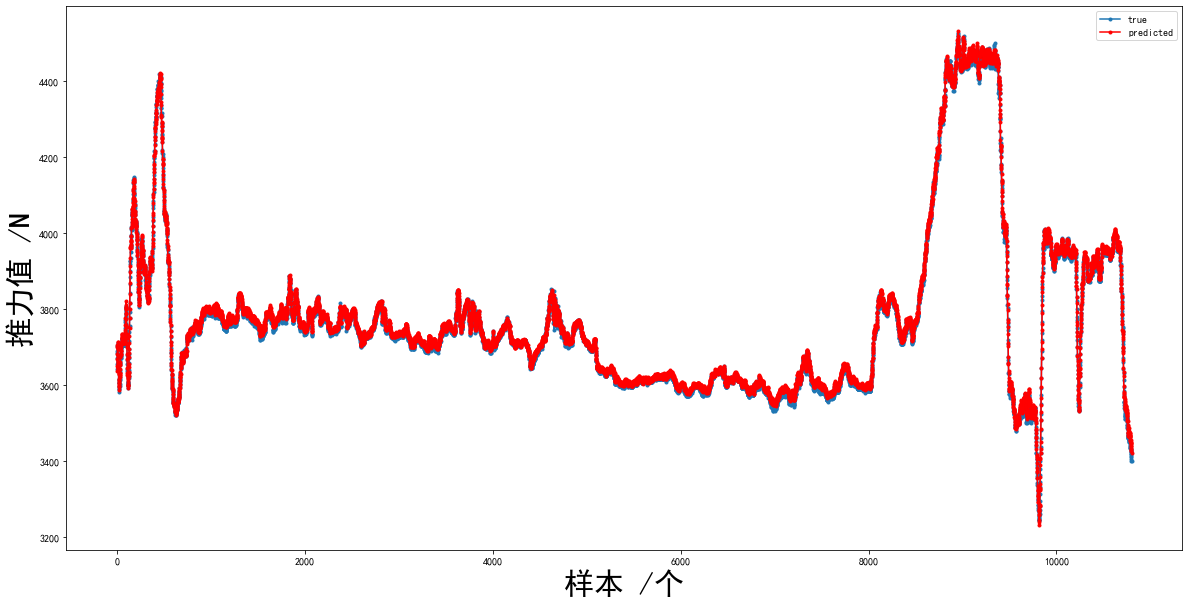

In [47]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot(predict_1[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend();